In [293]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import plotly.express as px
import duckdb
import os
from pathlib import Path
from typing import List
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px

In [294]:
# Afficher le répertoire de travail actuel
import os
print("Répertoire de travail actuel:", os.getcwd())

# Lister les fichiers et dossiers du répertoire parent
print("\nContenu du répertoire parent (..):")
print(os.listdir(".."))

# Lister les fichiers et dossiers deux niveaux au-dessus
print("\nContenu deux niveaux au-dessus (../..):")
try:
    print(os.listdir("../.."))
except FileNotFoundError:
    print("Impossible d'accéder à ce répertoire")

Répertoire de travail actuel: /home/c-enjalbert/Documents/EPSI/MSPR/bloc_2/amazing/ml_ia/item-based-clustering

Contenu du répertoire parent (..):
['item-based-clustering', 'analyse_exploratoire.ipynb', 'clustering']

Contenu deux niveaux au-dessus (../..):
['amazing.duckdb', 'ml_ia', '.amazing.duckdb', 'requirements.txt', '.git', 'Access_token.txt', 'README.md', 'etl', 'data', '.gitignore']


In [295]:
# Essayez différentes approches pour localiser le dossier data
possible_paths = [
    Path("../data"),             # Un niveau au-dessus
    Path("../../data"),          # Deux niveaux au-dessus
    Path("../../../data"),       # Trois niveaux au-dessus
    Path("../../../../data"),    # Quatre niveaux au-dessus
]

for path in possible_paths:
    if path.is_dir():
        print(f"Dossier data trouvé à : {path.resolve()}")
        data_folder = path
        break
else:
    print("Impossible de trouver le dossier data automatiquement")

Dossier data trouvé à : /home/c-enjalbert/Documents/EPSI/MSPR/bloc_2/amazing/data


### Connexion à la DB / Import des Data


In [296]:
# Store database at project root
DB_NAME = Path("/home/c-enjalbert/Documents/EPSI/MSPR/bloc_2/amazing/amazing.duckdb") 
# Go up one level from current directory to get to project root
data_folder = Path("../..").resolve() / "data"
# For absolute certainty, you could use the absolute path
# data_folder = Path("/home/c-enjalbert/Documents/EPSI/MSPR/bloc_2/amazing/data")
con = duckdb.connect(str(DB_NAME))

In [297]:
# 2. Query to list all tables in the database
# DuckDB specific way to list tables
tables_info = con.sql("""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'main'
    ORDER BY table_name
""").df()

print(f"Found {len(tables_info)} tables in the database:\n")

if len(tables_info) > 0:
    for i, table_name in enumerate(tables_info['table_name']):
        print(f"{i+1}. {table_name}")
else:
    print("No tables found in the database.")

Found 2 tables in the database:

1. all_events
2. loaded_files


In [298]:
# 5. Alternative way to show all tables
print("List of all tables using DuckDB's connections.tables():")
con.sql("SHOW TABLES").show()

List of all tables using DuckDB's connections.tables():
┌──────────────┐
│     name     │
│   varchar    │
├──────────────┤
│ all_events   │
│ loaded_files │
└──────────────┘



### Save Tables as DataFrame

In [299]:
# Get event counts by event_type
print("Event counts by type:")
all_events = con.sql("""
    SELECT 
    *
    FROM all_events
    LIMIT 20000
""")
all_events.show()



Event counts by type:
┌─────────────────────┬────────────┬────────────┬─────────────────────┬─────────────────────────────────────┬──────────┬─────────┬───────────┬──────────────────────────────────────┐
│     event_time      │ event_type │ product_id │     category_id     │            category_code            │  brand   │  price  │  user_id  │             user_session             │
│      timestamp      │  varchar   │  varchar   │       varchar       │               varchar               │ varchar  │ double  │  varchar  │               varchar                │
├─────────────────────┼────────────┼────────────┼─────────────────────┼─────────────────────────────────────┼──────────┼─────────┼───────────┼──────────────────────────────────────┤
│ 2019-10-01 00:00:00 │ view       │ 44600062   │ 2103807459595387724 │ NULL                                │ shiseido │   35.79 │ 541312140 │ 72d76fde-8bb3-4e00-8c23-a032dfed738c │
│ 2019-10-01 00:00:00 │ view       │ 3900821    │ 205301355232677090

In [300]:
all_events_df = pd.DataFrame(all_events.df())
all_events_df.describe(include="all").T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
event_time,20000,NaN,NaN,NaN,2019-10-01 02:29:27.043549,2019-10-01 00:00:00,2019-10-01 02:28:14.750000,2019-10-01 02:37:18,2019-10-01 02:46:00,2019-10-01 02:54:01,NaN
event_type,20000,3,view,19548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_id,20000,7178,1004856,234,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category_id,20000,443,2053013555631882655,5387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category_code,13412,115,electronics.smartphone,5387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand,17185,922,samsung,2330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,20000.0,NaN,NaN,NaN,289.381401,0.0,60.23,154.42,359.08,2574.07,368.18694
user_id,20000,5012,531063605,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_session,20000,5669,f85114d0-6167-4c8b-88f8-0cd1cfc2c10c,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Normalisation et Préparation de la Data 

In [301]:
all_events_df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [302]:
allevents_df_CF = all_events_df[["user_id", "product_id", "category_code", "category_id","event_type"]]

In [303]:
allevents_df_CF.shape


(20000, 5)

In [304]:
allevents_df_CF.describe(include="all").T

,count,unique,top,freq
user_id,20000,5012,531063605,57
product_id,20000,7178,1004856,234
category_code,13412,115,electronics.smartphone,5387
category_id,20000,443,2053013555631882655,5387
event_type,20000,3,view,19548


In [305]:
allevents_df_CF["product_id"].isna().sum()

0

In [306]:
allevents_df_CF["category_id"].isna().sum()

0

In [307]:
allevents_df_CF["category_code"].isna().sum()

6588

In [308]:
allevents_df_CF.dropna(subset=["category_code"], inplace=True)


/tmp/ipykernel_164509/2927840028.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [309]:
allevents_df_CF["category_code"].isna().sum()

0

In [310]:
allevents_df_CF["event_type"].isna().sum()

0

In [311]:
allevents_df_CF["event_type"].value_counts()

event_type
view        13037
purchase      200
cart          175
Name: count, dtype: int64

In [312]:
allevents_df_CF["user_id"].isna().sum()

0

On considère : 
- all_events_df["event_type"] = "view" ==> 0
- all_events_df["event_type"] = "cart" ==> 0
- all_events_df["event_type"] = "purchase" ==> 1

In [313]:
# Map event types to binary values (0 for view/cart, 1 for purchase)
all_events_df["event_type"] = all_events_df["event_type"].map({"view": 0, "cart": 0, "purchase": 1})

In [314]:
all_events_df["event_type"].value_counts()

event_type
0    19742
1      258
Name: count, dtype: int64

In [315]:
all_events_df["category_code"].value_counts()

category_code
electronics.smartphone                 5387
electronics.clocks                      664
computers.notebook                      633
electronics.audio.headphone             437
appliances.kitchen.refrigerators        390
                                       ... 
electronics.audio.music_tools.piano       1
apparel.scarf                             1
apparel.shirt                             1
apparel.sock                              1
sport.ski                                 1
Name: count, Length: 115, dtype: int64

/tmp/ipykernel_164509/2036899418.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




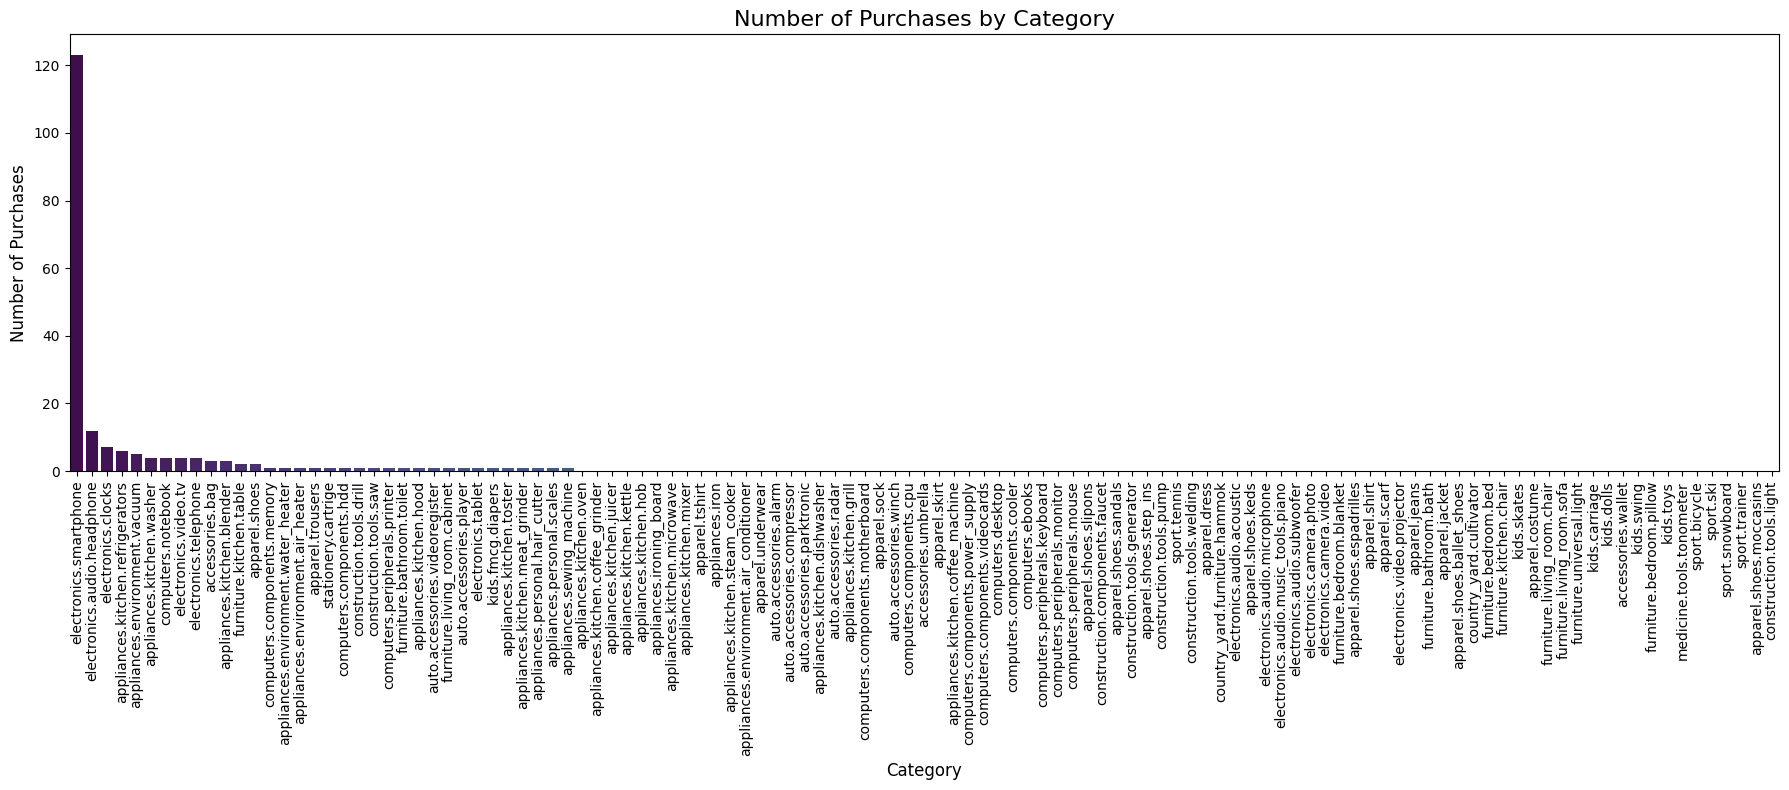

In [316]:
plt.figure(figsize=(18, 8))
ax = sns.barplot(x='category_code', y='event_type', data=category_purchase_counts, palette='viridis')
plt.title('Number of Purchases by Category', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Purchases', fontsize=12)
plt.xticks(rotation=90)  # Rotate x labels vertically
plt.tight_layout()
plt.show()

In [317]:
cf_dataset = all_events_df.copy().groupby(by=['user_id','category_code'], as_index=False).agg({"event_type":"mean"})

cf_dataset.head()

,user_id,category_code,event_type
0,306441847,appliances.kitchen.oven,0.0
1,434894256,computers.notebook,0.0
2,442188017,computers.peripherals.monitor,0.0
3,443779465,electronics.clocks,0.0
4,444990139,electronics.smartphone,0.0


In [318]:
num_users = len(cf_dataset['user_id'].value_counts())
num_items = len(cf_dataset['category_code'].value_counts())
print('Unique number of product in the dataset: {}'.format(num_users))
print('Unique number of category in the dataset: {}'.format(num_items))


Unique number of product in the dataset: 3591
Unique number of category in the dataset: 115


In [319]:
purchased_count_df = pd.DataFrame(cf_dataset.groupby(['event_type']).size(), columns=['count'])
purchased_count_df

,count
event_type,
0.000000,3970
0.037037,2
0.041667,1
0.055556,1
0.058824,1
0.062500,2
0.071429,2
0.076923,1
0.083333,2


Text(0, 0.5, 'number of purchase event')

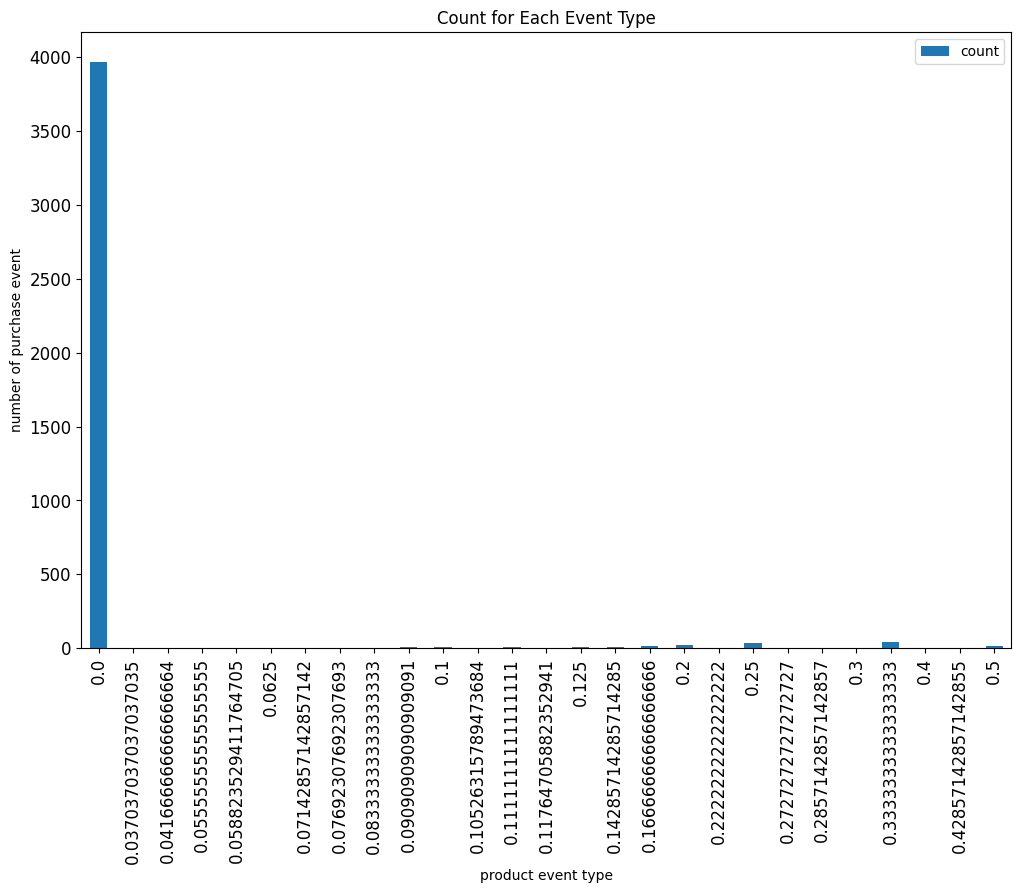

In [320]:
ax = purchased_count_df.reset_index().rename(columns={'index': 'event_type'}).plot('event_type','count', 'bar',
    figsize=(12, 8),
    title='Count for Each Event Type',
    fontsize=12)

ax.set_xlabel("product event type")
ax.set_ylabel("number of purchase event")

In [321]:
# pivot and create product-user matrix
user_to_product_df = cf_dataset.pivot(
    index='user_id',
     columns='category_code',
      values='event_type').fillna(0)

user_to_product_df.head()

category_code,accessories.bag,accessories.umbrella,accessories.wallet,apparel.costume,apparel.dress,apparel.jacket,apparel.jeans,apparel.scarf,apparel.shirt,apparel.shoes,...,kids.skates,kids.swing,kids.toys,medicine.tools.tonometer,sport.bicycle,sport.ski,sport.snowboard,sport.tennis,sport.trainer,stationery.cartrige
user_id,,,,,,,,,,,,,,,,,,,,,
306441847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
434894256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
442188017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
443779465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
444990139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [322]:
# transform matrix to scipy sparse matrix
user_to_product_sparse_df = csr_matrix(user_to_product_df.values)
user_to_product_sparse_df

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 180 stored elements and shape (3591, 115)>

**Fitting K-Nearest Neighbours model to the scipy sparse matrix:**

In [323]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_to_product_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine')

In [324]:
## function to find top n similar users of the given input user 
def get_similar_users(user, n = 5):
  ## input to this function is the user and number of top similar users you want.

  knn_input = np.asarray([user_to_product_df.values[user-1]])  #.reshape(1,-1)
  # knn_input = user_to_movie_df.iloc[0,:].values.reshape(1,-1)
  distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
  
  print("Top",n,"users who are very much similar to the User-",user, "are: ")
  print(" ")
  for i in range(1,len(distances[0])):
    print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
  return indices.flatten()[1:] + 1, distances.flatten()[1:]


**Specify User id and Number of similar users we want to consider here**

In [325]:
from pprint import pprint
user_id = 778
print(" Few of product seen by the User:")
pprint(list(cf_dataset[cf_dataset['user_id'] == user_id]['category_code'])[:10])
similar_user_list, distance_list = get_similar_users(user_id,5)

 Few of product seen by the User:
[]
Top 5 users who are very much similar to the User- 778 are: 
 
1 . User: 2397 separated by distance of 1.0
2 . User: 2393 separated by distance of 1.0
3 . User: 2396 separated by distance of 1.0
4 . User: 2392 separated by distance of 1.0
5 . User: 2394 separated by distance of 1.0


In [326]:
con.close()